#### Required Libraries

In [1]:
import sys
sys.path.append('/scratch/mz2476/DL/project/')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import copy
import random

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
# from torchsummary import summary

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box, compute_ts_road_map
from modelzoo import *

#### VAE Model Summary

In [3]:
# model = vae()
# inp = torch.rand([3,6,3,256,306])
# model.summarize(inp)

# summary(model, (6,3,256,306), batch_size=2)

#### AE Model Summary

In [4]:
# model = autoencoder()
# inp = torch.rand([3,6,3,256,306])
# model.summarize(inp)

### Setting project details

In [5]:
# matplotlib.rcParams['figure.figsize'] = [5, 5]
# matplotlib.rcParams['figure.dpi'] = 200

seed = 8964

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed);

# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = torchvision.transforms.ToTensor()

In [6]:
from ssl_project.data_loaders.splits import get_train_val_test_ds
import learner

In [7]:
from importlib import reload

In [8]:
reload(learner)

<module 'learner' from '/scratch/mz2476/DL/project/ssl_project/road_layout_prediction/learner.py'>

In [9]:
train_labeled_set, val_labeled_set, _ = get_train_val_test_ds([2,3,4,5], extra_info=False)

train scene idces: [106 107 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133], 
val scene idces: [108 109 110 111]
len(train_labeled_set)=3024, len(val_labeled_set)=504


In [15]:
checkpoint_folder = '/scratch/sc6957/dlproject/checkpoints/'
tensorboard_log_dir = '/scratch/sc6957/dlproject/tb_logs'

batch_size = 16
resnet_style = '18'
weights = 'random'
model_type ='vae'
num_epochs = 25
threshold = 0.5
restore = False # Restore from checkpoint, if checkpoint exists

model_tag = '_Batch:{}_Model:{}'.format(batch_size,model_type+resnet_style+weights)

print('model_tag:{}'.format(model_tag))

my_learner = learner.Learner(
    model_tag=model_tag,
    device=device,
    resnet_style=resnet_style,
    weights=weights,
    model_type=model_type,
    checkpoint_folder='/scratch/mz2476/DL/project/checkpoints/',
    tensorboard_log_dir='/scratch/mz2476/DL/project/tb_logs',
)
    
# parameters = prepare_experiment(model_tag = model_tag, batch_size = batch_size, resnet_style = resnet_style, weights = weights, model_type = model_type, checkpoint_folder = checkpoint_folder)

# model, optimizer, scheduler, criterion, dataloaders, checkpoint_path, best_checkpoint_path = parameters   

model_tag:_Batch:16_Model:vae18random
Model Type: vae
vae Model Summary
Class: vae
Passed Input Size:torch.Size([4, 6, 3, 256, 306])
----
     Class: encoder
     resnet_style: 18, pretrained: False
     Passed Input Size:torch.Size([4, 3, 256, 306])
     Output Size:torch.Size([4, 512, 8, 8])
----
Number of encoded states: 6, each of size: torch.Size([4, 512, 8, 8])
Concatenated encoded states shape: torch.Size([4, 3072, 8, 8])
----
     Class: encoder_after_resnet
     Passed Input Size:torch.Size([4, 3072, 8, 8])
     Convolved Encoded state shape: torch.Size([4, 512, 4, 4])
     Output Mean Size:torch.Size([4, 4096])
     Output Var Size:torch.Size([4, 4096])
----
Output Mean Size:torch.Size([4, 4096])
Output Var Size:torch.Size([4, 4096])
Reparameterized Hidden State size: torch.Size([4, 4096])
----
     Class: vae_decoder
     Passed Input Size:torch.Size([4, 4096])
     Input recast into shape: torch.Size([4, 64, 8, 8])
     Output Size:torch.Size([4, 800, 800])
----
Output Size

In [16]:
# my_learner.model = model

#### Training and Validation

In [17]:
my_learner.init_loaders(train_labeled_set, val_labeled_set, batch_size=batch_size)

In [43]:
my_learner.train(4, threshold=0.5, tensorboard_log_dir=tensorboard_log_dir)

Epoch 2/3
----------



train running_loss: 0.0273



val running_loss: 0.3718 cumulative_threat_score: 349.0746 val_len: 504 
 mean_threat_score: 0.6926
best_loss model after 4 epoch saved...
model after 4 epoch saved...
Epoch 3/3
----------



train running_loss: 0.0274



val running_loss: 0.3711 cumulative_threat_score: 351.9698 val_len: 504 
 mean_threat_score: 0.6984
best_loss model after 5 epoch saved...
best_ts model after 5 epoch saved...
model after 5 epoch saved...


In [19]:
len(train_labeled_set)

3024

In [ ]:
tqdm

In [22]:
ans = torch.zeros((800, 800))

for i in tqdm(range(0, len(train_labeled_set), 20)): #len(train_labeled_set)):
    ans += train_labeled_set[i][2]


100%|██████████| 152/152 [00:09<00:00, 16.78it/s]


In [26]:
target = torch.zeros((800, 800))

for i in tqdm(range(0, len(val_labeled_set), 5)): #len(train_labeled_set)):
    target += val_labeled_set[i][2]


100%|██████████| 101/101 [00:12<00:00,  8.12it/s]


In [24]:
ans / len(train_labeled_set)

tensor([[0.0053, 0.0053, 0.0053,  ..., 0.0073, 0.0069, 0.0069],
        [0.0056, 0.0053, 0.0056,  ..., 0.0069, 0.0069, 0.0069],
        [0.0056, 0.0056, 0.0056,  ..., 0.0073, 0.0073, 0.0073],
        ...,
        [0.0060, 0.0060, 0.0060,  ..., 0.0060, 0.0060, 0.0060],
        [0.0060, 0.0060, 0.0063,  ..., 0.0060, 0.0060, 0.0060],
        [0.0060, 0.0063, 0.0063,  ..., 0.0060, 0.0060, 0.0060]])

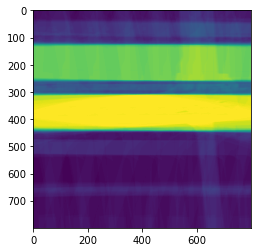

In [27]:
plt.imshow(target / len(train_labeled_set))

In [31]:
ans.max()

tensor(152.)

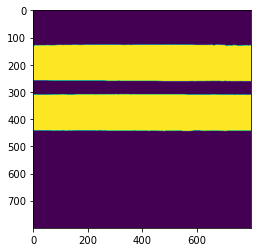

In [33]:
plt.imshow(ans > 100)

In [28]:
from helper import compute_ts_road_map

In [34]:
scores = []

for i in tqdm(range(0, len(val_labeled_set), 5)): #len(train_labeled_set)):
    scores.append(compute_ts_road_map(ans > 100, val_labeled_set[i][2]))


100%|██████████| 101/101 [00:00<00:00, 209.67it/s]


In [38]:
torch.FloatTensor(scores).mean()

tensor(0.7178)

Estimating performance on val set
Test Batch: 0


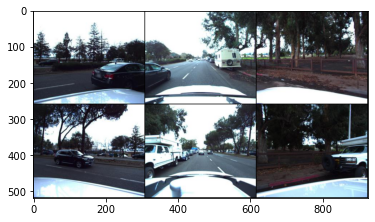

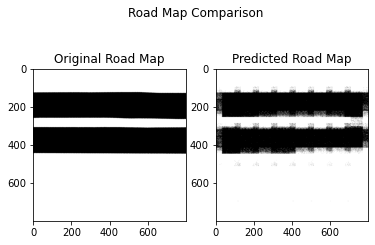

--------------------
Test Batch: 20


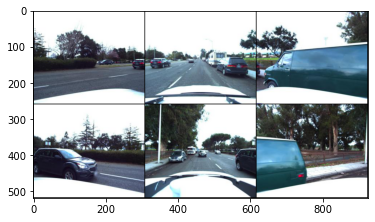

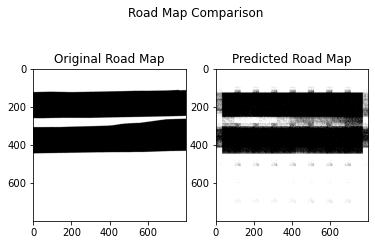

--------------------
Test Batch: 40


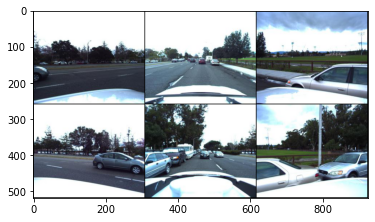

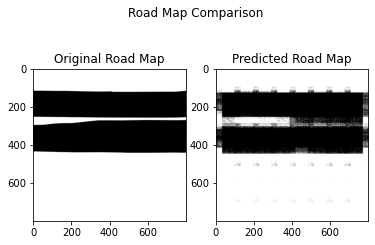

--------------------
Test Batch: 60


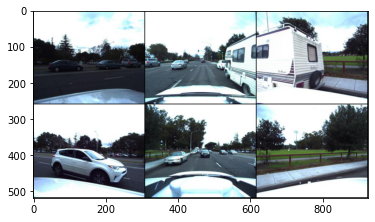

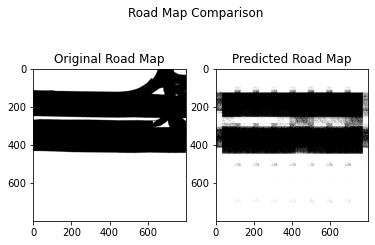

--------------------
Test Batch: 80


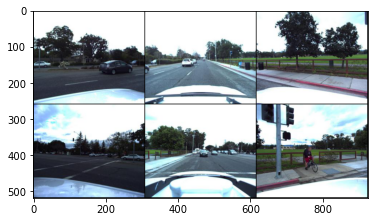

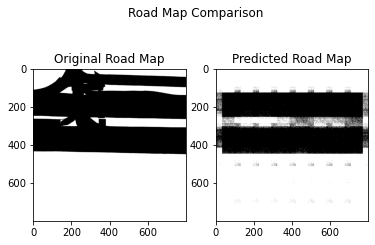

--------------------
Test Batch: 100


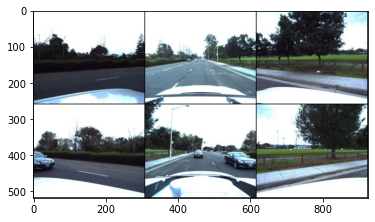

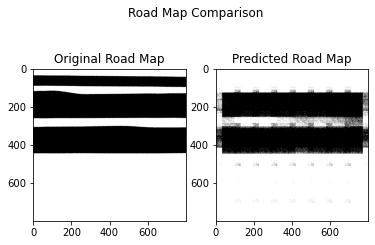

--------------------
Test Batch: 120


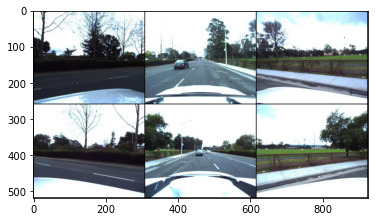

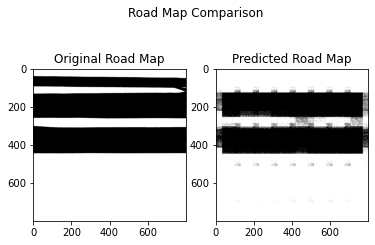

--------------------
Test Batch: 140


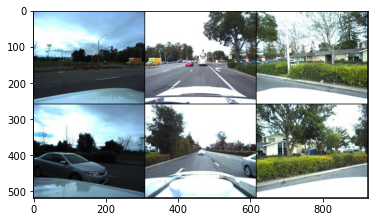

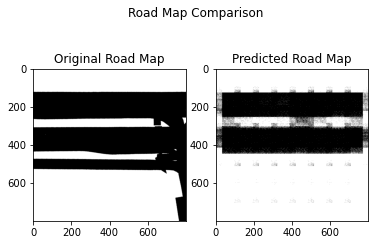

--------------------
Test Batch: 160


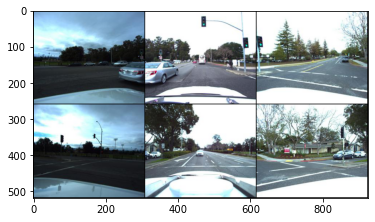

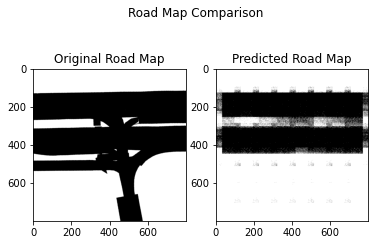

--------------------
Test Batch: 180


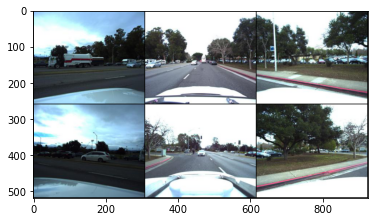

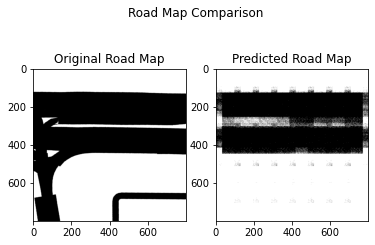

--------------------
Test Batch: 200


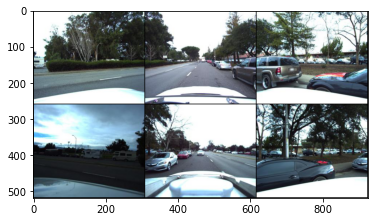

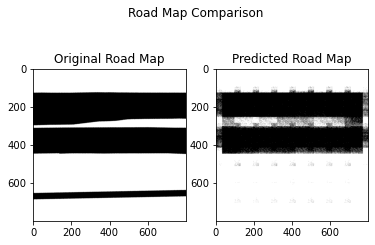

--------------------
Test Batch: 220


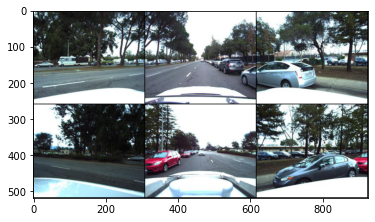

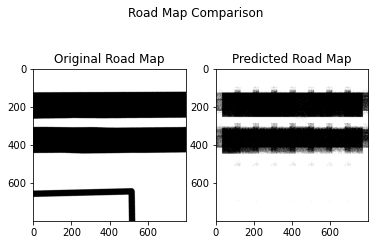

--------------------
Test Batch: 240


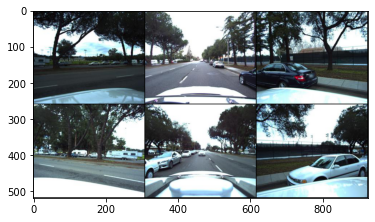

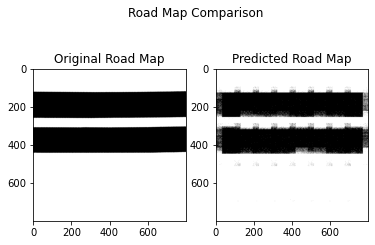

--------------------
Test Batch: 260


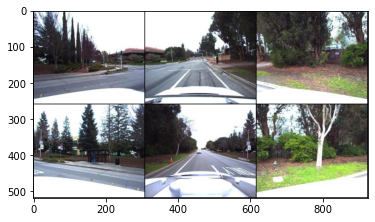

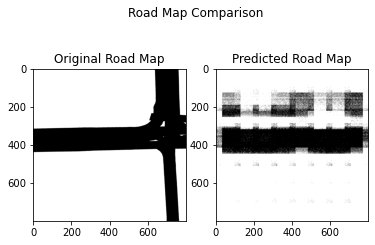

--------------------
Test Batch: 280


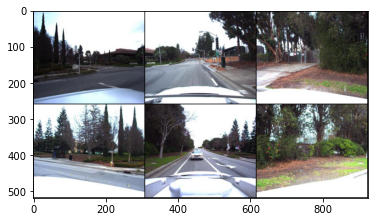

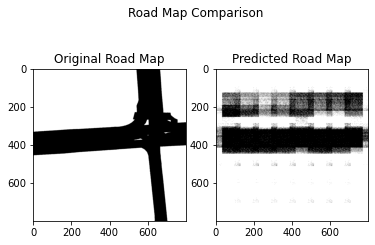

--------------------
Test Batch: 300


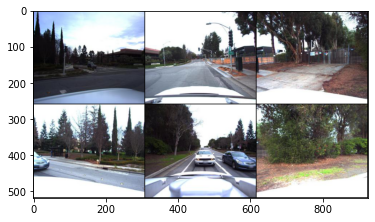

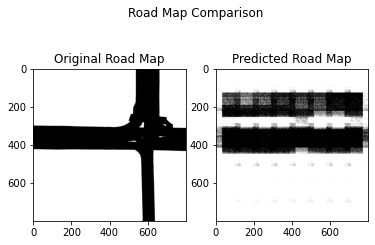

--------------------
Test Batch: 320


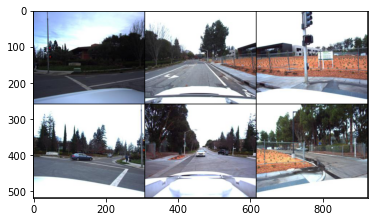

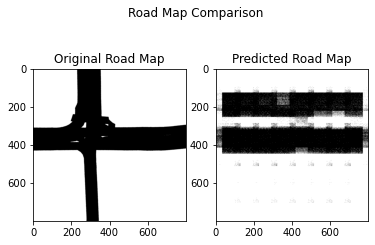

--------------------
Test Batch: 340


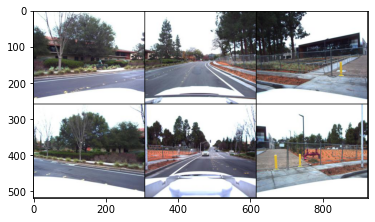

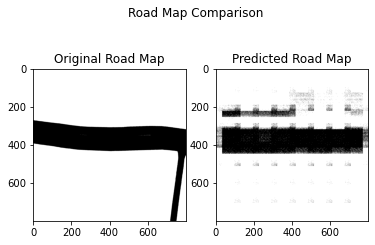

--------------------
Test Batch: 360


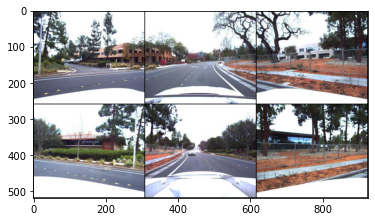

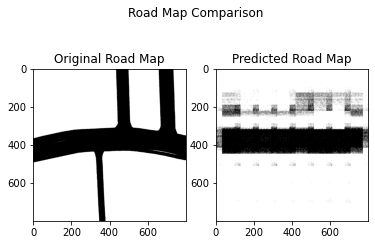

--------------------
Test Batch: 380


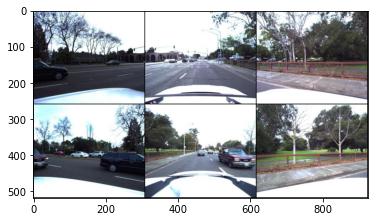

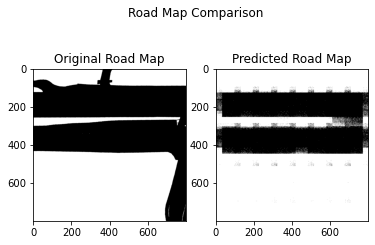

--------------------
Test Batch: 400


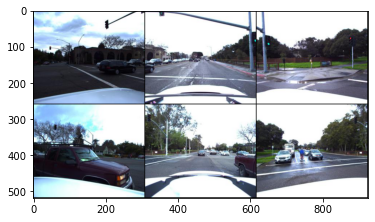

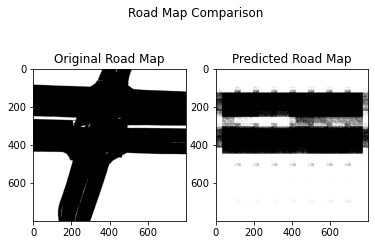

--------------------
Test Batch: 420


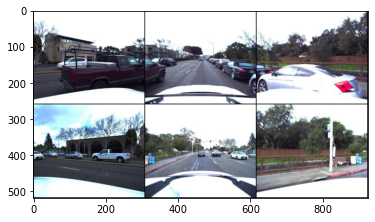

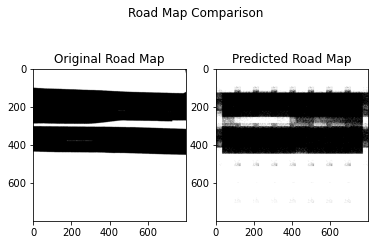

--------------------
Test Batch: 440


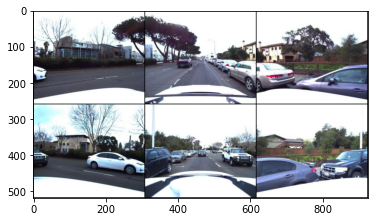

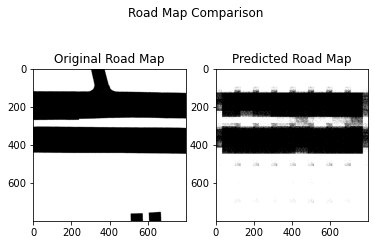

--------------------
Test Batch: 460


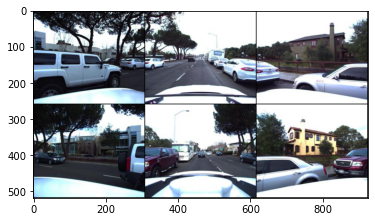

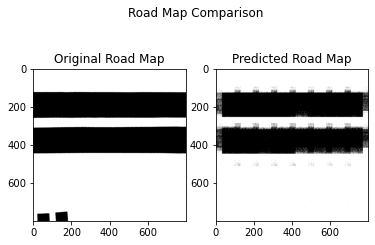

--------------------
Test Batch: 480


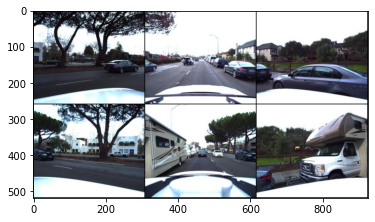

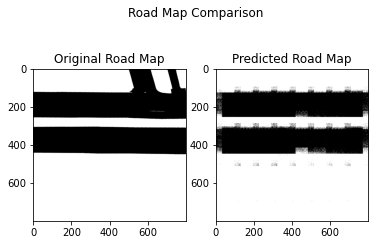

--------------------
Test Batch: 500


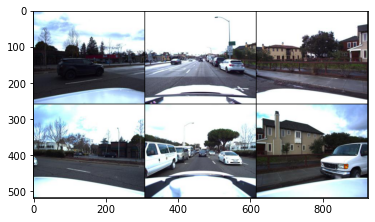

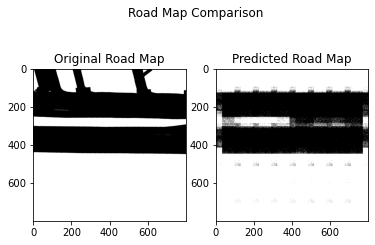

--------------------
Total samples: 26.0, Total Threat Score: 18.240734100341797
Mean Threat Score is: 0.7015666961669922


In [39]:
my_learner.report_loss("val", None, batches_idces_to_display=slice(None, None, 20))

### Evaluation & Analysis

In [ ]:
nn.BCELoss()

In [ ]:
torch.utils.data.DataLoader()

In [28]:
def evaluate(model, model_type, model_path, dataloaders, phase, display_images = False, n_batch_to_display = 3, threshold = 0.5):
    
    assert phase != 'unlabeled'
    
    print('Estimating performance on {} set'.format(phase))
    print('Restoring Best checkpoint from {}'.format(model_path))
    state = torch.load(model_path)
    epoch = state['epoch']
    model.load_state_dict(state['state_dict'])
    
    model.eval()

    threat_score = 0.0
    total = 0.0
    
    for i, temp_batch in enumerate(dataloaders[phase]):
        if display_images and i == n_batch_to_display:
            break
        total += len(temp_batch[0])
        samples, targets, road_images, extra = temp_batch
        samples = torch.stack(samples).to(device)
        road_images = torch.stack(road_images).to(device)
        if model_type == 'ae':
            pred_maps = model(samples)
        elif model_type == 'vae':
            pred_maps, mu, logvar = model(samples,is_training=False)

        for pred_map,road_image in zip(pred_maps,road_images):
            ts_road_map = compute_ts_road_map(pred_map > threshold, road_image)
            threat_score += ts_road_map

        if display_images:
            for sample,pred_map,road_image in zip(samples,pred_maps,road_images):
                print('Test Batch: {}'.format(i))
                # CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
                plt.imshow(torchvision.utils.make_grid(sample.detach().cpu(), nrow=3).numpy().transpose(1, 2, 0))
                fig, (ax1, ax2) = plt.subplots(1, 2)
                fig.suptitle('Road Map Comparison')
                ax1.imshow(road_image.detach().cpu(), cmap='binary');
                ax1.set_title('Original Road Map')
                ax2.imshow((pred_map > threshold).detach().cpu(), cmap='binary');
                ax2.set_title('Predicted Road Map')
                plt.show()
                print('-'*20)

    threat_score /= total
    print('Total samples: {}, Total Threat Score: {}'.format(total,total*threat_score))
    print('Mean Threat Score is: {}'.format(threat_score))

### Verifying Performance on Test (Val & Train) set

In [31]:
# evaluate(model, model_type, best_checkpoint_path, dataloaders,  'test', display_images = True , n_batch_to_display = 10, threshold = 0.5)
evaluate(model, model_type, best_checkpoint_path, dataloaders,  'val', display_images = False , n_batch_to_display = 1, threshold = 0.5)
# evaluate(model, model_type, best_checkpoint_path, dataloaders,  'train', display_images = True , n_batch_to_display = 1, threshold = 0.5)

Estimating performance on val set
Restoring Best checkpoint from /scratch/sc6957/dlproject/checkpoints/checkpoint_26-4_Batch:16_Model:vae18random_dataV3_best.pth.tar
Total samples: 378.0, Total Threat Score: 317.6849060058594
Mean Threat Score is: 0.8404362201690674


### Measure performance of all models trained so far

In [85]:
# trained_best_models_list = ['ae_checkpoint25-4-res50-random_best.pth.tar'
# ,'ae_checkpoint4-24-res18-random_best.pth.tar'
# ,'ae_checkpoint_6img_132_p100_best.pth.tar'
# ,'checkpoint_25-4_Batch:8_Model:ae18random_best.pth.tar'
# ,'vae_checkpoint25-4-res18-random_best.pth.tar'
# ,'vae_checkpoint25-4-res50-random_best.pth.tar'
# ,'vae_checkpoint_6img_132_p100_best.pth.tar'
# ,'vae_checkpoint_random_132_p100_best.pth.tar',
# 'checkpoint_25-4_Batch:16_Model:vae18random_best.pth.tar']

# path_to_checkpoints = '/home/sc6957/dlproject/code/checkpoints/'

In [ ]:
current_checkpoint_folder = '/scratch/sc6957/dlproject/checkpoints/'
old_checkpoint_folder = '/scratch/sc6957/dlproject/old_checkpoints/'

current_trained_best_models_list = ['']

old_trained_best_models_list = ['ae_checkpoint25-4-res50-random_best.pth.tar'
,'ae_checkpoint4-24-res18-random_best.pth.tar'
,'ae_checkpoint_6img_132_p100_best.pth.tar'
,'checkpoint_25-4_Batch:8_Model:ae18random_best.pth.tar'
,'vae_checkpoint25-4-res18-random_best.pth.tar'
,'vae_checkpoint25-4-res50-random_best.pth.tar'
,'vae_checkpoint_6img_132_p100_best.pth.tar'
,'vae_checkpoint_random_132_p100_best.pth.tar',
'checkpoint_25-4_Batch:16_Model:vae18random_best.pth.tar']

trained_best_models_list = old_trained_best_models_list
path_to_checkpoints = old_checkpoint_folder

start_ind = 0
end_ind = len(old_trained_best_models_list)

In [86]:
for name in trained_best_models_list[start_ind:end_ind]:
    current_model_path = path_to_checkpoints + name
    
    resnet_style = '18'
    if '50' in current_model_path:
        resnet_style = '50'
    
    model_type = 'ae'
    if 'vae' in current_model_path:
        model_type = 'vae'
    
    print(current_model_path)
    print('Creating model with Resnet Style: {0}, Model Type: {1}'.format(resnet_style,model_type))

    if model_type == 'ae':
        model = autoencoder(resnet_style=resnet_style,pretrained=False)
    elif model_type == 'vae':
        model = vae(resnet_style=resnet_style,pretrained=False)
    
    model = model.to(device)
    print('-------')
    evaluate(model, model_type, current_model_path, dataloaders,  'test', display_images = False)
    evaluate(model, model_type, current_model_path, dataloaders,  'val', display_images = False)
    print('-------'*4)

/home/sc6957/dlproject/code/checkpoints/vae_checkpoint25-4-res18-random_best.pth.tar
Creating model with Resnet Style: 18, Model Type: vae
-------
Estimating performance on test set
Restoring Best checkpoint from /home/sc6957/dlproject/code/checkpoints/vae_checkpoint25-4-res18-random_best.pth.tar
Total samples: 252.0, Total Threat Score: 219.46495056152344
Mean Threat Score is: 0.8708926439285278
Estimating performance on val set
Restoring Best checkpoint from /home/sc6957/dlproject/code/checkpoints/vae_checkpoint25-4-res18-random_best.pth.tar
Total samples: 491.0, Total Threat Score: 462.19647216796875
Mean Threat Score is: 0.941336989402771
----------------------------


### Unlabeled testing

In [35]:
unlabeled_scene_index = np.arange(106)
#test_unlabeled_scene_index = np.arange(1,3)

unlabeled_set = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='sample', transform=transform)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_set, batch_size=3, shuffle=True, num_workers=4)
dataloaders.update({'unlabeled':unlabeled_loader})

In [36]:
def evaluate_unlabeled(model, model_type, model_path, phase, display_images = False, n_batch_to_display = 3, threshold = 0.5):
    assert phase == 'unlabeled'
    print('Estimating performance on {} set'.format(phase))
    print('Restoring Best checkpoint from {}'.format(model_path))
    state = torch.load(model_path)
    epoch = state['epoch']
    model.load_state_dict(state['state_dict'])
    
    model.eval()

    total = 0.0
    for i, temp_batch in enumerate(dataloaders[phase]):
        if display_images and i == n_batch_to_display:
            break
        total += len(temp_batch)
        samples = temp_batch.to(device)
        if model_type == 'ae':
            pred_maps = model(samples)
        elif model_type == 'vae':
            pred_maps, mu, logvar = model(samples,is_training=False)


        if display_images:
            print('Test Batch: {}'.format(i))
            for sample,pred_map in zip(samples,pred_maps):
                # CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
                plt.imshow(torchvision.utils.make_grid(sample.detach().cpu(), nrow=3).numpy().transpose(1, 2, 0))
                fig, ax = plt.subplots(1, 1)
                ax.imshow((pred_map > threshold).detach().cpu(), cmap='binary');
                ax.set_title('Predicted Road Map')
                plt.show()
                print('-'*20)
                
    print('Total samples: {}'.format(total))

In [39]:
best_checkpoint_path = '/scratch/sc6957/dlproject/checkpoints/checkpoint_26-4_Batch:16_Model:vae18random_dataV3_best.pth.tar'

Estimating performance on unlabeled set
Restoring Best checkpoint from /scratch/sc6957/dlproject/checkpoints/checkpoint_26-4_Batch:16_Model:vae18random_dataV3_best.pth.tar
Test Batch: 0


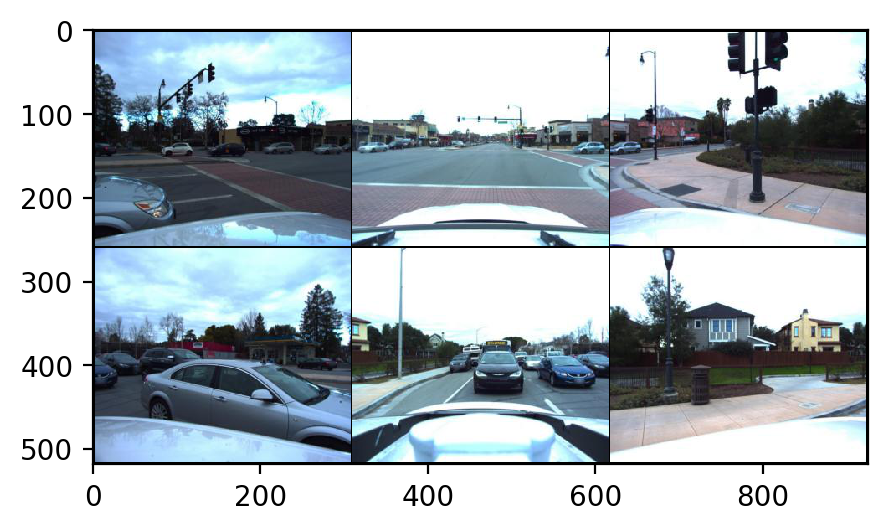

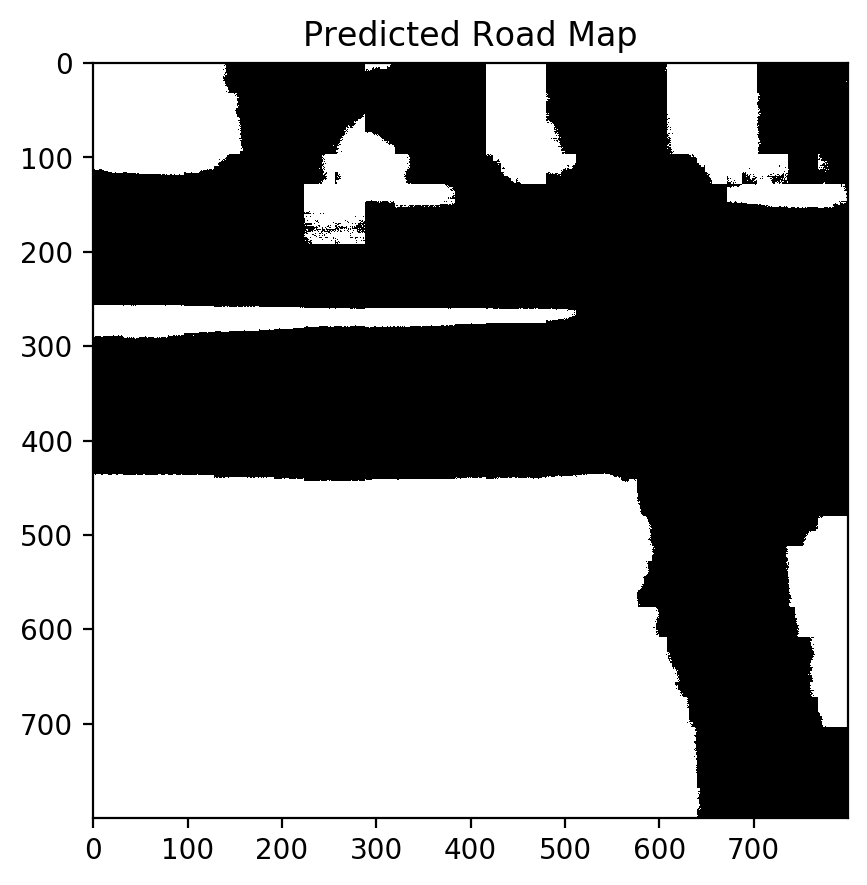

--------------------


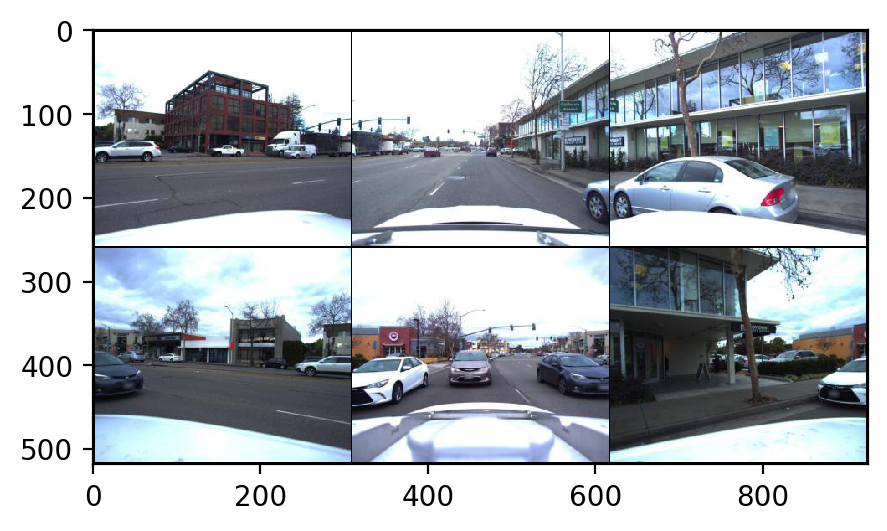

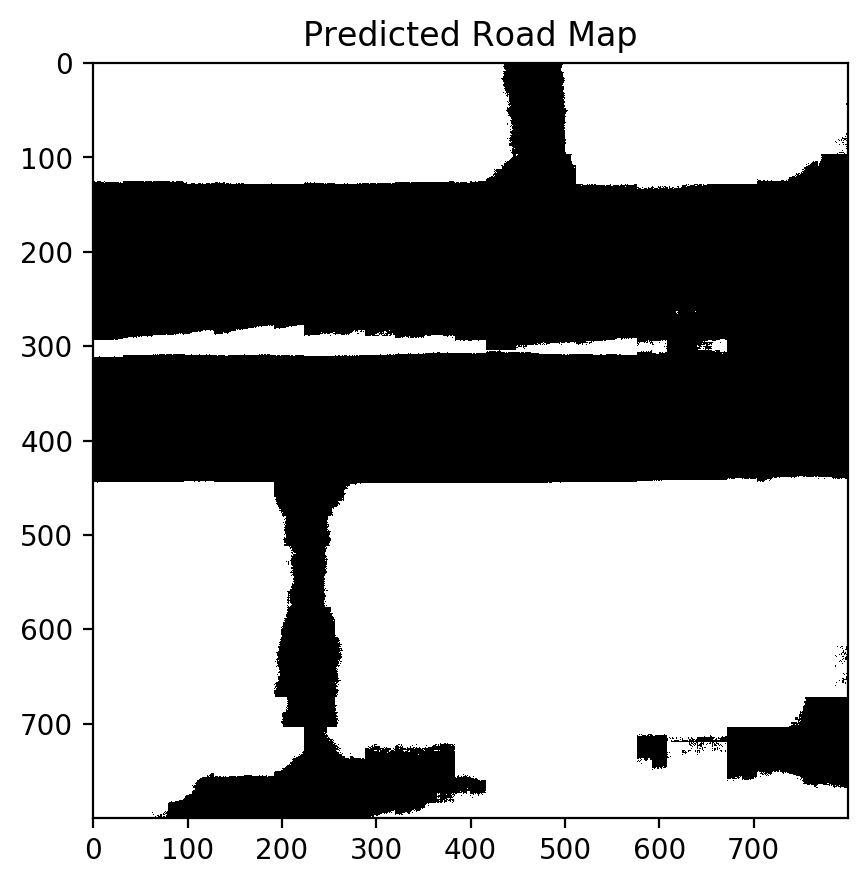

--------------------


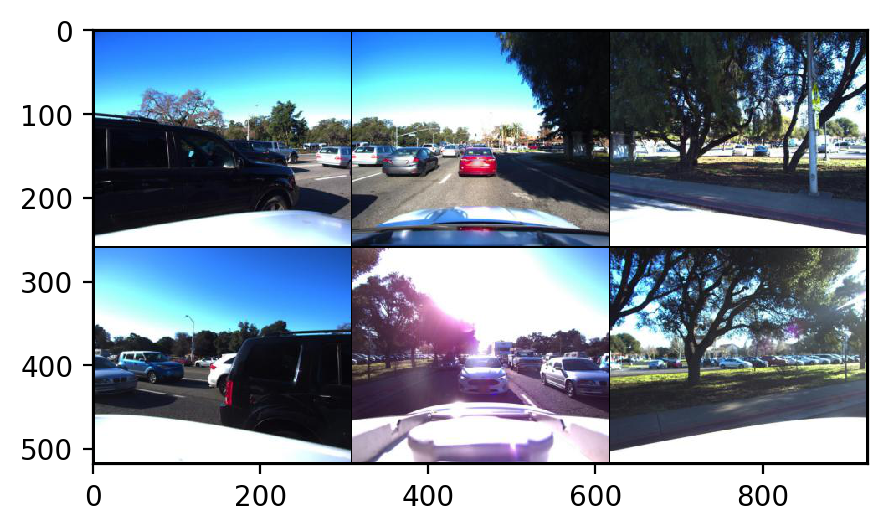

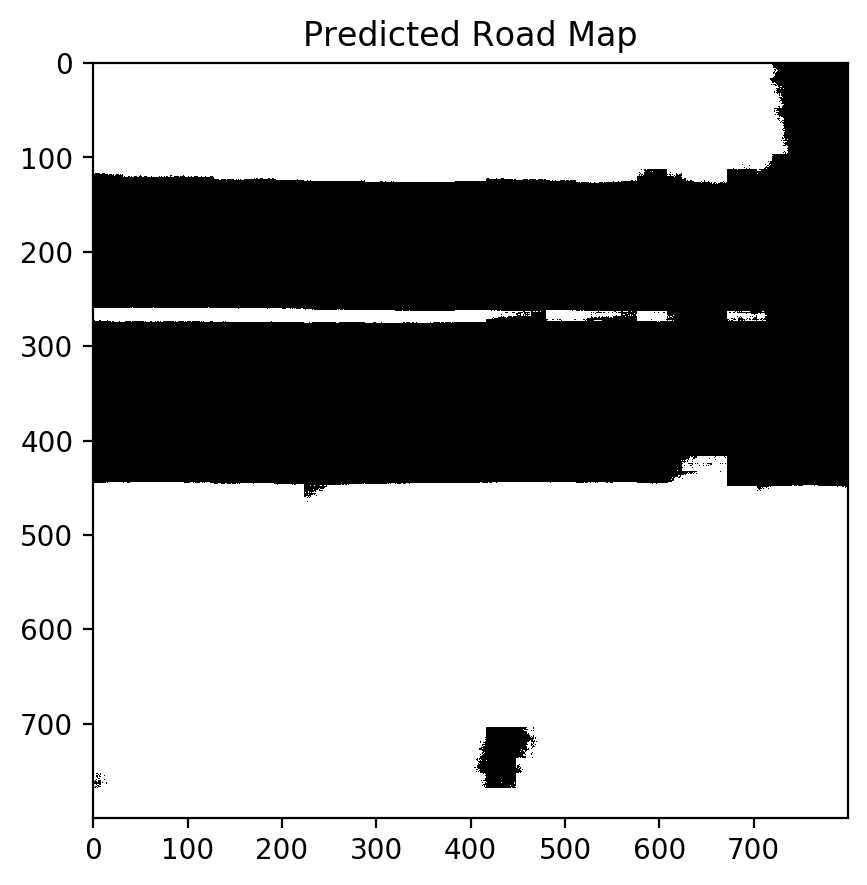

--------------------
Total samples: 3.0


In [40]:
evaluate_unlabeled(model, model_type, best_checkpoint_path, 'unlabeled', \
                   display_images = True , n_batch_to_display = 1, threshold = 0.4)